### NYC Taxi Trip Analysis (yr 2019 - 2021)

#### Read Data

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, date_format, dayofweek, month, count, avg, max, min, to_date, to_timestamp, sum, when, dayofweek

import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from graphframes import *

import pyspark.sql.functions as F 
from pyspark.sql.functions import udf, explode, col,lit, split, regexp_replace, regexp_extract
from pyspark.sql.types import StringType, ArrayType

import numpy as np

In [4]:
# spark = SparkSession.builder.appName('App')\
#         .config("spark.executor.cores",'16')\
#         .config("spark.executor.memory", '60g')\
#         .getOrCreate()
spark = SparkSession.builder.appName('App2').getOrCreate()

In [5]:
df2021 = spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hyrn/2021_Yellow_Taxi_Trip_Data_full.csv")
df2020 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2020_Yellow_Taxi_Trip_Data_full.csv")
df2019 =spark.read.option("header", "true").option("inferSchema", "true").csv("gs://project_hynr2/2019_Yellow_Taxi_Trip_Data_full.csv")

In [4]:
# df2021 = df2021.withColumn("Datayear", lit(2021))
# df2020 = df2020.withColumn("Datayear", lit(2020))
# df2019 = df2019.withColumn("Datayear", lit(2019))

In [5]:
# union_df = df2021.union(df2020).union(df2019)

#### Sampling Data

In [6]:
sampled_2021 = df2021.sample(fraction=0.001, seed=12)
sampled_2020 = df2020.sample(fraction=0.001, seed=34)
sampled_2019 = df2019.sample(fraction=0.001, seed=56)

In [7]:
sampled_2021 = sampled_2021.withColumn("Datayear", lit(2021))
sampled_2020 = sampled_2020.withColumn("Datayear", lit(2020))
sampled_2019 = sampled_2019.withColumn("Datayear", lit(2019))

In [8]:
print(sampled_2021 .count(),len(sampled_2021 .columns))

31103 19


In [9]:
sampled_2021.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)



In [10]:
sampled_2021.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+
|       2|01/01/2021 01:45:...| 01/01/2021 02:00:...|              1|         4.62|         1|                 N|          50|          74|           2|       15.5|  0.5|    0.5|       0.0|       

In [9]:
union_df = sampled_2021.union(sampled_2020).union(sampled_2019)

#### Check Number of Partitions - Equally partitioned

In [12]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

In [13]:
#number of partitions
union_df.rdd.getNumPartitions()

103

In [14]:
#re-partition the data to evenly distributed across 32 partitions
union_df = union_df.repartition(32)
displaypartitions(union_df)

Partitions: 32


+-----------+-----+
|partitionId|count|
+-----------+-----+
|         23| 4331|
|         22| 4335|
|         21| 4337|
|         20| 4339|
|         19| 4345|
|         18| 4352|
|         17| 4358|
|         16| 4362|
|         15| 4366|
|         14| 4369|
|         13| 4374|
|         12| 4378|
|         11| 4382|
|         10| 4386|
|          9| 4387|
|          8| 4390|
|          7| 4393|
|          6| 4394|
|          5| 4396|
|          3| 4401|
|          4| 4401|
|          2| 4403|
|          1| 4404|
|          0| 4409|
|         31| 4411|
|         30| 4413|
|         29| 4414|
|         28| 4418|
|         27| 4420|
|         26| 4424|
|         25| 4426|
|         24| 4429|
+-----------+-----+



#### Feature Engineering

In [10]:
# change to date type
union_df = union_df.withColumn("parsed_pickup_datetime", to_timestamp("tpep_pickup_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df = union_df.withColumn("parsed_dropoff_datetime", to_timestamp("tpep_dropoff_datetime", "MM/dd/yyyy hh:mm:ss a"))
union_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)



In [11]:
# calcualte average spent per mile and avergae spent per min
union_df = union_df.withColumn("PerMile", col("total_amount") / col("trip_distance"))

#df2021Full = df2021Full.withColumn("Dur",  col("parsed_dropoff_datetime") - col("parsed_pickup_datetime"))
from pyspark.sql.functions import datediff, minute, hour
union_df = union_df.withColumn("Dur", datediff("parsed_dropoff_datetime", "parsed_pickup_datetime") * 24 * 60 +hour("parsed_dropoff_datetime")* 60-hour("parsed_pickup_datetime")*60
+ minute("parsed_dropoff_datetime") - minute("parsed_pickup_datetime"))

union_df = union_df.withColumn("PerMin", col("total_amount") / col("Dur"))
union_df = union_df.withColumn("Speed", col("trip_distance") / col("Dur"))

In [17]:
union_df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+--------+----------------------+-----------------------+------------------+---+------------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Datayear|parsed_pickup_datetime|parsed_dropoff_datetime|           PerMile|Dur|            PerMin|              Speed|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------

#### Visualize the pickup & dropoff locations

In [18]:
union_df.select('PULocationID','DOLocationID').show()

+------------+------------+
|PULocationID|DOLocationID|
+------------+------------+
|          74|          75|
|         236|         237|
|         140|          79|
|         239|         238|
|         100|         116|
|         142|         161|
|         229|         233|
|          48|         170|
|         163|         100|
|         107|         237|
|         236|         262|
|         143|         142|
|         132|         256|
|          75|         182|
|         161|         164|
|         246|         237|
|         239|         229|
|         162|          48|
|         107|          75|
|         100|         140|
+------------+------------+
only showing top 20 rows



In [13]:
# Read taxi_zone data to get longitude/latitude data
import geopandas as gpd
import pandas as pd

# Read the shapefile into a geopandas dataframe
gdf = gpd.read_file("gs://project_hynr2/taxi_zones.zip")

# Convert the geopandas dataframe to a pandas dataframe
df = gdf.drop(columns='geometry')
df[['longitude', 'latitude']] = gdf['geometry'].apply(lambda p: pd.Series(p.centroid.coords[0]))

In [14]:
df

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.359968e+05,191376.749531
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.031086e+06,164018.754403
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.026453e+06,254265.478659
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.906340e+05,202959.782391
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.318714e+05,140681.351376
...,...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,1.025106e+06,266453.414552
259,260,0.133514,0.000422,Woodside,260,Queens,1.010212e+06,210434.891894
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,9.806395e+05,197635.173702
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,9.990647e+05,221974.400788


In [15]:
df = df.drop(columns = 'OBJECTID')

In [16]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

# define the schema of the PySpark DataFrame
schema = StructType([
    StructField("Shape_Leng", DoubleType()),
    StructField("Shape_Area", DoubleType()),
    StructField("zone", StringType()),
    StructField("LocationID", IntegerType()),
    StructField("borough", StringType()),
    StructField("longitude", DoubleType()),
    StructField("latitude", DoubleType())
])

# convert the pandas DataFrame to PySpark DataFrame
taxi_zone = spark.createDataFrame(df, schema=schema)

In [23]:
taxi_zone.printSchema()

root
 |-- Shape_Leng: double (nullable = true)
 |-- Shape_Area: double (nullable = true)
 |-- zone: string (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- borough: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)



In [24]:
taxi_zone.show()

+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
|     Shape_Leng|      Shape_Area|                zone|LocationID|      borough|         longitude|          latitude|
+---------------+----------------+--------------------+----------+-------------+------------------+------------------+
| 0.116357453189|  7.823067885E-4|      Newark Airport|         1|          EWR| 935996.8210162065|191376.74953083202|
|  0.43346966679|0.00486634037837|         Jamaica Bay|         2|       Queens|1031085.7186032843|164018.75440320166|
|0.0843411059012|3.14414156821E-4|Allerton/Pelham G...|         3|        Bronx|1026452.6168734727|254265.47865856893|
|0.0435665270921|1.11871946192E-4|       Alphabet City|         4|    Manhattan| 990633.9806410479| 202959.7823911368|
|0.0921464898574|4.97957489363E-4|       Arden Heights|         5|Staten Island| 931871.3700680139|140681.35137597343|
| 0.150490542523|6.06460984581E-4|Arrochar/Fort 

In [17]:
joined_df = union_df.join(taxi_zone, col("PULocationID") == col("LocationID"),"inner")

In [18]:
joined_df = joined_df.drop('LocationID','Shape_leng','Shape_Area')
joined_df = joined_df.withColumnRenamed("longitude", "PUlongitude")\
            .withColumnRenamed("latitude","PUlatitude")\
            .withColumnRenamed("zone","PUzone")\
            .withColumnRenamed("borough","PUborough")

In [19]:
joined_df = joined_df.join(taxi_zone, col("DOLocationID") == col("LocationID"),"inner")

In [20]:
joined_df = joined_df.drop('LocationID')
joined_df = joined_df.withColumnRenamed("longitude", "DOlongitude")\
            .withColumnRenamed("latitude","DOlatitude")\
            .withColumnRenamed("zone","DOzone")\
            .withColumnRenamed("borough","DOborough")
joined_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Datayear: integer (nullable = false)
 |-- parsed_pickup_datetime: timestamp (nullable = true)
 |-- parsed_dropoff_datetime: timestamp (nullable = true)
 |-- PerMile: dou

#### Analyze which regions have most pickups and drop-offs?

In [29]:
# Find most pickup locations
from pyspark.sql.functions import desc

most_pickup_loc = joined_df.groupBy('PULocationID','PUzone','PUborough','PUlongitude','PUlatitude') \
                       .count() \
                       .orderBy(desc('count'))

In [30]:
most_pickup_loc.show()

+------------+--------------------+---------+------------------+------------------+-----+
|PULocationID|              PUzone|PUborough|       PUlongitude|        PUlatitude|count|
+------------+--------------------+---------+------------------+------------------+-----+
|         237|Upper East Side S...|Manhattan| 993769.0237137815|219305.82782555217| 6308|
|         236|Upper East Side N...|Manhattan| 996155.3867656847| 223613.7535760244| 5898|
|         161|      Midtown Center|Manhattan|  990428.525989642| 215447.5272239114| 5421|
|         186|Penn Station/Madi...|Manhattan| 986345.3986004688| 211974.4462185665| 4947|
|         162|        Midtown East|Manhattan| 991908.5895678961|214959.58164229896| 4902|
|         170|         Murray Hill|Manhattan| 990209.6000586881|211701.31597992923| 4328|
|         142| Lincoln Square East|Manhattan| 989365.0684741095| 221132.7753491493| 4288|
|         230|Times Sq/Theatre ...|Manhattan| 988628.0600467023| 216099.1397683868| 4286|
|         

In [31]:
most_pickup_borough = joined_df.groupBy('PUborough') \
                       .count() \
                       .orderBy(desc('count'))

In [32]:
#most_pickup_borough.show()

In [33]:
# Find most pickup locations
most_dropoff_loc = joined_df.groupBy('DOLocationID','DOzone','DOborough','DOlongitude','DOlatitude') \
                       .count() \
                       .orderBy(desc('count'))

In [34]:
most_dropoff_loc.show()

+------------+--------------------+---------+-----------------+------------------+-----+
|DOLocationID|              DOzone|DOborough|      DOlongitude|        DOlatitude|count|
+------------+--------------------+---------+-----------------+------------------+-----+
|         236|Upper East Side N...|Manhattan|996155.3867656847| 223613.7535760244| 5988|
|         237|Upper East Side S...|Manhattan|993769.0237137815|219305.82782555217| 5706|
|         161|      Midtown Center|Manhattan| 990428.525989642| 215447.5272239114| 5094|
|         170|         Murray Hill|Manhattan|990209.6000586881|211701.31597992923| 4346|
|         162|        Midtown East|Manhattan|991908.5895678961|214959.58164229896| 4034|
|         142| Lincoln Square East|Manhattan|989365.0684741095| 221132.7753491493| 3778|
|         230|Times Sq/Theatre ...|Manhattan|988628.0600467023| 216099.1397683868| 3697|
|         141|     Lenox Hill West|Manhattan|995431.1975186545| 218699.1927268597| 3682|
|          48|       

In [35]:
# Find most pickup locations
most_dropoff_borough = joined_df.groupBy('DOborough') \
                       .count() \
                       .orderBy(desc('count'))

In [36]:
most_dropoff_borough.show()

+-------------+------+
|    DOborough| count|
+-------------+------+
|    Manhattan|123745|
|       Queens|  7114|
|     Brooklyn|  5910|
|        Bronx|  1245|
|          EWR|   287|
|Staten Island|    47|
+-------------+------+



Both Top 20 pickup & Top 20 dropoff locations are in Manhattan borough.

In [ ]:
pickup_df = most_pickup_loc.toPandas()
dropoff_df = most_dropoff_loc.toPandas()

In [ ]:
pu_borough = most_pickup_borough.toPandas()
do_borough = most_dropoff_borough.toPandas()

In [ ]:
pickup_df

In [ ]:
dropoff_df

In [ ]:
pu_borough

In [ ]:
do_borough

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

dobo_df = pu_borough

# Load the NYC shapefile using geopandas
nyc_shapefile = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile")

# Merge the data with the NYC shapefile
merged = nyc_shapefile.merge(dobo_df, left_on='boro_name', right_on='PUborough')

# Create a choropleth map of the count of dropoff trips in each DOborough
ax = merged.plot(column='count', cmap='ocean_r', edgecolor='k', linewidth=0.5, legend=True, legend_kwds={'label': "Count of Pickups"})
ax.set_title("Num of Pickups in each borough")

# Remove axes and set aspect ratio to equal
ax.set_axis_off()
ax.set_aspect('equal')

# Loop through each geometry in the GeoDataFrame and add a text label at the centroid
for idx, row in merged.iterrows():
    ax.annotate(text=row['PUborough'], xy=row['geometry'].centroid.coords[0], color='black', fontsize=6, ha='center')

# Show the plot
plt.show()

In [ ]:
dobo_df = do_borough

# Merge the data with the NYC shapefile
merged = nyc_shapefile.merge(dobo_df, left_on='boro_name', right_on='DOborough')

# Create a choropleth map of the count of dropoff trips in each DOborough
ax = merged.plot(column='count', cmap='ocean_r', edgecolor='k', linewidth=0.5, legend=True, legend_kwds={'label': "Count of Dropoffs"})
ax.set_title("Num of Dropoffs in each borough")

# Remove axes and set aspect ratio to equal
ax.set_axis_off()
ax.set_aspect('equal')

# Loop through each geometry in the GeoDataFrame and add a text label at the centroid
for idx, row in merged.iterrows():
    ax.annotate(text=row['DOborough'], xy=row['geometry'].centroid.coords[0], color='black', fontsize=6, ha='center')
    
# Show the plot
plt.show()

#### Zone with most pickups for short trips/ zone with most pickups for long trips

In [ ]:
union_df.select('trip_distance').describe().show()

According to the dustribution of trip distances (very right skewed) and the fact that it takes about 30 miles to drive across the whole New York City, we decided to use 30 as the number to split the trips into short or long distance trips.

Will need to adjust threshold when using FULL Dataset

In [ ]:
short_trip = joined_df.filter(F.col('trip_distance')<30)

In [ ]:
long_trip = joined_df.filter(F.col('trip_distance')>= 30)

In [ ]:
from pyspark.sql.functions import desc
short_trip_PUzone = short_trip.groupby('PULocationID','PUzone','PUborough')\
                    .count().orderBy(desc('count'))

In [ ]:
long_trip_PUzone = long_trip.groupby('PULocationID','PUzone','PUborough')\
                    .count().orderBy(desc('count'))

In [ ]:
short_trip_DOzone = short_trip.groupby('DOLocationID','DOzone','DOborough')\
                    .count().orderBy(desc('count'))

In [ ]:
long_trip_DOzone = long_trip.groupby('DOLocationID','DOzone','DOborough')\
                    .count().orderBy(desc('count'))

In [ ]:
short_trip_PUzone.show()

In [ ]:
long_trip_PUzone.show()

Looks like most long trips are picked up from JFL Airports.

In [ ]:
short_trip_DOzone.show()

In [ ]:
long_trip_DOzone.show()

Most dropoff for long trips are also airports (Newark and JFK).

#### Peak hours and Off-peak hours for taking taxi

In [ ]:
union_df = union_df.withColumn('pu_hour',hour('parsed_pickup_datetime'))

In [ ]:
union_df = union_df.withColumn('do_hour',hour('parsed_dropoff_datetime'))

In [ ]:
pu_hour_df = union_df.groupby('pu_hour')\
            .agg(F.count('*').alias('PU_count')).orderBy('pu_hour')
do_hour_df = union_df.groupby('do_hour')\
            .agg(F.count('*').alias('DO_count')).orderBy('do_hour')

In [ ]:
pu_df = pu_hour_df.toPandas()
do_df = do_hour_df.toPandas()

In [ ]:
pu_df

In [ ]:
# Plot pickup and dropoff counts on the same plot
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(pu_df['pu_hour'], pu_df['PU_count'], label='Pickup')
ax.plot(do_df['do_hour'], do_df['DO_count'], label='Dropoff')

ax.set_title('Pickup and Dropoff Counts by Hour')
ax.set_xlabel('Hour')
ax.set_ylabel('Count')

ax.legend()
plt.show()

Pickup and Dropoff has about the same counts by hour, with 4-5 am being the most off-peak hours and 4pm to 7pm being the peak-hours.

#### Visualize Pickup Counts by Month over 3 years (2019-2021)

In [ ]:
# Extract the month and day of week from pickup time
union_df = union_df.withColumn("pickup_month", month("parsed_pickup_datetime"))
union_df = union_df.withColumn("pickup_dayofweek", dayofweek("parsed_pickup_datetime"))
union_df.printSchema()

In [ ]:
# Create a dummy variable of weekday
union_df = union_df.withColumn("pickup_weekday", when((union_df["pickup_dayofweek"] >= 2) & (union_df["pickup_dayofweek"] <= 6), 1).otherwise(0))
union_df.printSchema()

In [ ]:
# Create a season variable
union_df = union_df.withColumn(
    "season",
    when((union_df.pickup_month <= 2) | (union_df.pickup_month == 12), 1)
    .when((union_df.pickup_month >= 3) & (union_df.pickup_month <= 5), 2)
    .when((union_df.pickup_month >= 6) & (union_df.pickup_month <= 8), 3)
    .otherwise(4),
)

In [ ]:
# Data Type Transformation
# Convert store_and_fwd_flag to a dummy variable
union_df = union_df.withColumn("store_and_fwd_flag", 
                               when(union_df.store_and_fwd_flag == "Y", 1).otherwise(0))


In [ ]:
# Aggregate data by year and month
yearmonth_df = union_df.groupBy("Datayear", "pickup_month") \
                     .agg(sum("fare_amount").alias("fare"),
                          sum("total_amount").alias("total"),
                          sum("tip_amount").alias("tip"),
                          sum("trip_distance").alias("distance"),
                          count("*").alias("pickup_count"))

# Calculate averages
yearmonth_df = yearmonth_df.withColumn("avg_fare", F.col("fare") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_total", F.col("total") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_tip", F.col("tip") / F.col("pickup_count"))
yearmonth_df = yearmonth_df.withColumn("avg_distance", F.col("distance") / F.col("pickup_count"))

In [ ]:
yearmonth_plot = yearmonth_df.toPandas()

In [ ]:
# Convert year and month to datetime and set as index
yearmonth_plot['date'] = pd.to_datetime(yearmonth_plot['Datayear'].astype(str) + '-' + yearmonth_plot['pickup_month'].astype(str) + '-01')
yearmonth_plot.set_index('date', inplace=True)

# Sort the DataFrame by date
yearmonth_plot = yearmonth_plot.sort_index()

# Filter data from 2019 to 2021
# yearmonth_plot = yearmonth_plot.loc['2019':'2021']

# Create a new figure
plt.figure(figsize=(10, 3))

# Plot pickup count
plt.plot(yearmonth_plot.index, yearmonth_plot["pickup_count"], marker='o')
plt.title('Pickup Counts by month from 2019 to 2021')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a new figure
plt.figure(figsize=(10, 3))

# Plot average trip distance
plt.plot(yearmonth_plot.index, yearmonth_plot["avg_distance"], marker='o')
plt.title('Average Trip Distance by month from 2019 to 2021')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Graph Computing - NYC Taxi Network

In [21]:
taxi_zone = taxi_zone.withColumn("id",taxi_zone["zone"])

joined_df = joined_df.withColumn("src", joined_df["PUzone"])
joined_df = joined_df.withColumn("dst", joined_df["DOzone"])

In [22]:
from graphframes import *

In [23]:
graph = GraphFrame(taxi_zone, joined_df)

In [ ]:
graph.vertices.show(5)

In [ ]:
graph.edges.count()

In [24]:
degree = graph.degrees.orderBy('degree', ascending=False)
degree.show(10)

+--------------------+------+
|                  id|degree|
+--------------------+------+
|Upper East Side S...| 12014|
|Upper East Side N...| 11886|
|      Midtown Center| 10515|
|        Midtown East|  8936|
|         Murray Hill|  8674|
|Penn Station/Madi...|  8328|
| Lincoln Square East|  8066|
|Times Sq/Theatre ...|  7983|
|        Clinton East|  7872|
|            Union Sq|  7554|
+--------------------+------+
only showing top 10 rows



As expected, Upper East Side South and Upper East Side North are the top3 zones with the highest degree.

In [25]:
# compute the indegree of each vertex
indegree = graph.inDegrees.orderBy('inDegree', ascending=False)
indegree.show(10)

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|Upper East Side N...|    5988|
|Upper East Side S...|    5706|
|      Midtown Center|    5094|
|         Murray Hill|    4346|
|        Midtown East|    4034|
| Lincoln Square East|    3778|
|Times Sq/Theatre ...|    3697|
|     Lenox Hill West|    3682|
|        Clinton East|    3669|
|Upper West Side S...|    3656|
+--------------------+--------+
only showing top 10 rows



In [26]:
# compute the outdegree of each vertex
outdegree = graph.outDegrees.orderBy('outDegree', ascending=False)
outdegree.show(10)

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|Upper East Side S...|     6308|
|Upper East Side N...|     5898|
|      Midtown Center|     5421|
|Penn Station/Madi...|     4947|
|        Midtown East|     4902|
|         Murray Hill|     4328|
| Lincoln Square East|     4288|
|Times Sq/Theatre ...|     4286|
|         JFK Airport|     4285|
|        Clinton East|     4203|
+--------------------+---------+
only showing top 10 rows



In [27]:
graph.inDegrees.orderBy('inDegree', ascending=True).show(10)

+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|     Pelham Bay Park|       1|
|     Freshkills Park|       1|
|        Astoria Park|       1|
|         Great Kills|       1|
|New Dorp/Midland ...|       1|
|       Broad Channel|       1|
|       Arden Heights|       1|
|         Westerleigh|       1|
| Green-Wood Cemetery|       2|
|Breezy Point/Fort...|       2|
+--------------------+--------+
only showing top 10 rows



In [ ]:
graph.outDegrees.orderBy('outDegree', ascending=True).show(10)

In [28]:
# rank by most popular routes
RouteCount = graph.edges.groupBy("src","dst").count().orderBy("count", ascending=False)
RouteCount.show(10)

+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|Upper East Side S...|Upper East Side N...|  922|
|Upper East Side N...|Upper East Side S...|  872|
|Upper East Side S...|Upper East Side S...|  736|
|Upper East Side N...|Upper East Side N...|  727|
|Upper East Side S...|      Midtown Center|  387|
|Upper East Side S...|        Midtown East|  381|
| Lincoln Square East|Upper West Side S...|  375|
|Upper West Side S...| Lincoln Square East|  371|
|Upper West Side S...|Upper West Side N...|  369|
|      Midtown Center|Upper East Side S...|  353|
+--------------------+--------------------+-----+
only showing top 10 rows



In [29]:


def plotGraph(pdf):
    G = nx.from_pandas_edgelist(pdf[:50], "src", "dst", edge_attr=True, create_using=nx.MultiDiGraph())
    counts = [i['count'] / 100 for i in dict(G.edges).values()]

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    edge_colors = range(len(G.edges()))  # Example: Assigning a range of colors to edges

    nx.draw(
        G,
        with_labels=True,
        node_color='skyblue',
        width=counts,
        #length=3,
        edge_cmap=plt.cm.Blues,
        edge_color='pink',
        font_size=12,
        #edge_colors = (0.24, 0.24, 0.0), # Set the edge color
        pos=pos
    )
    plt.show()


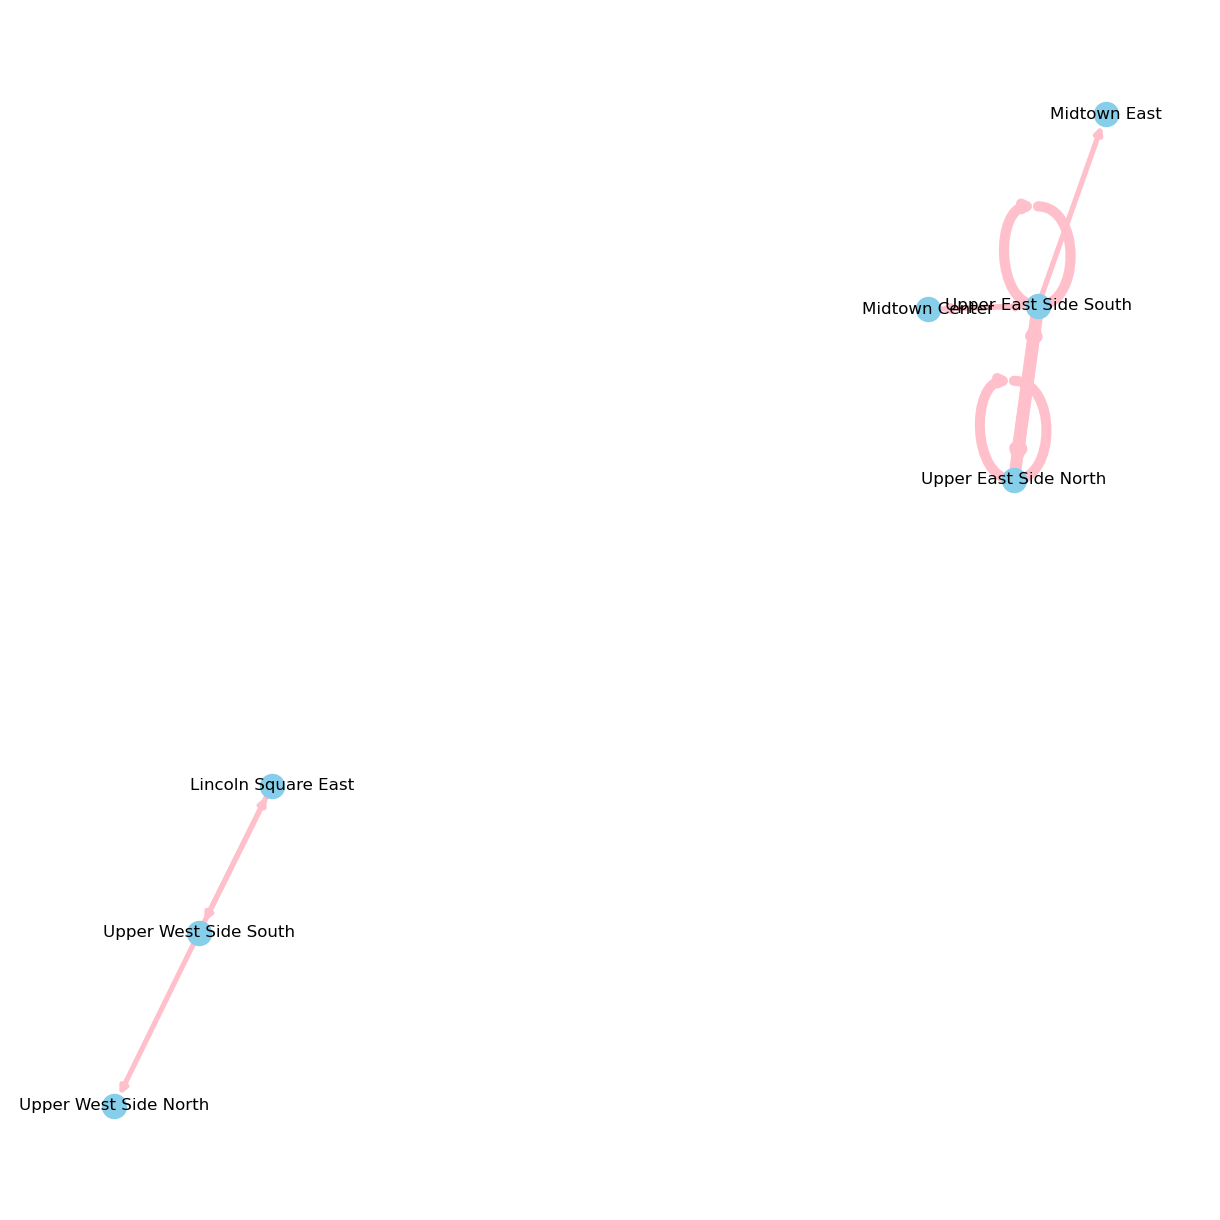

In [30]:
plotGraph(RouteCount.toPandas()[:10])

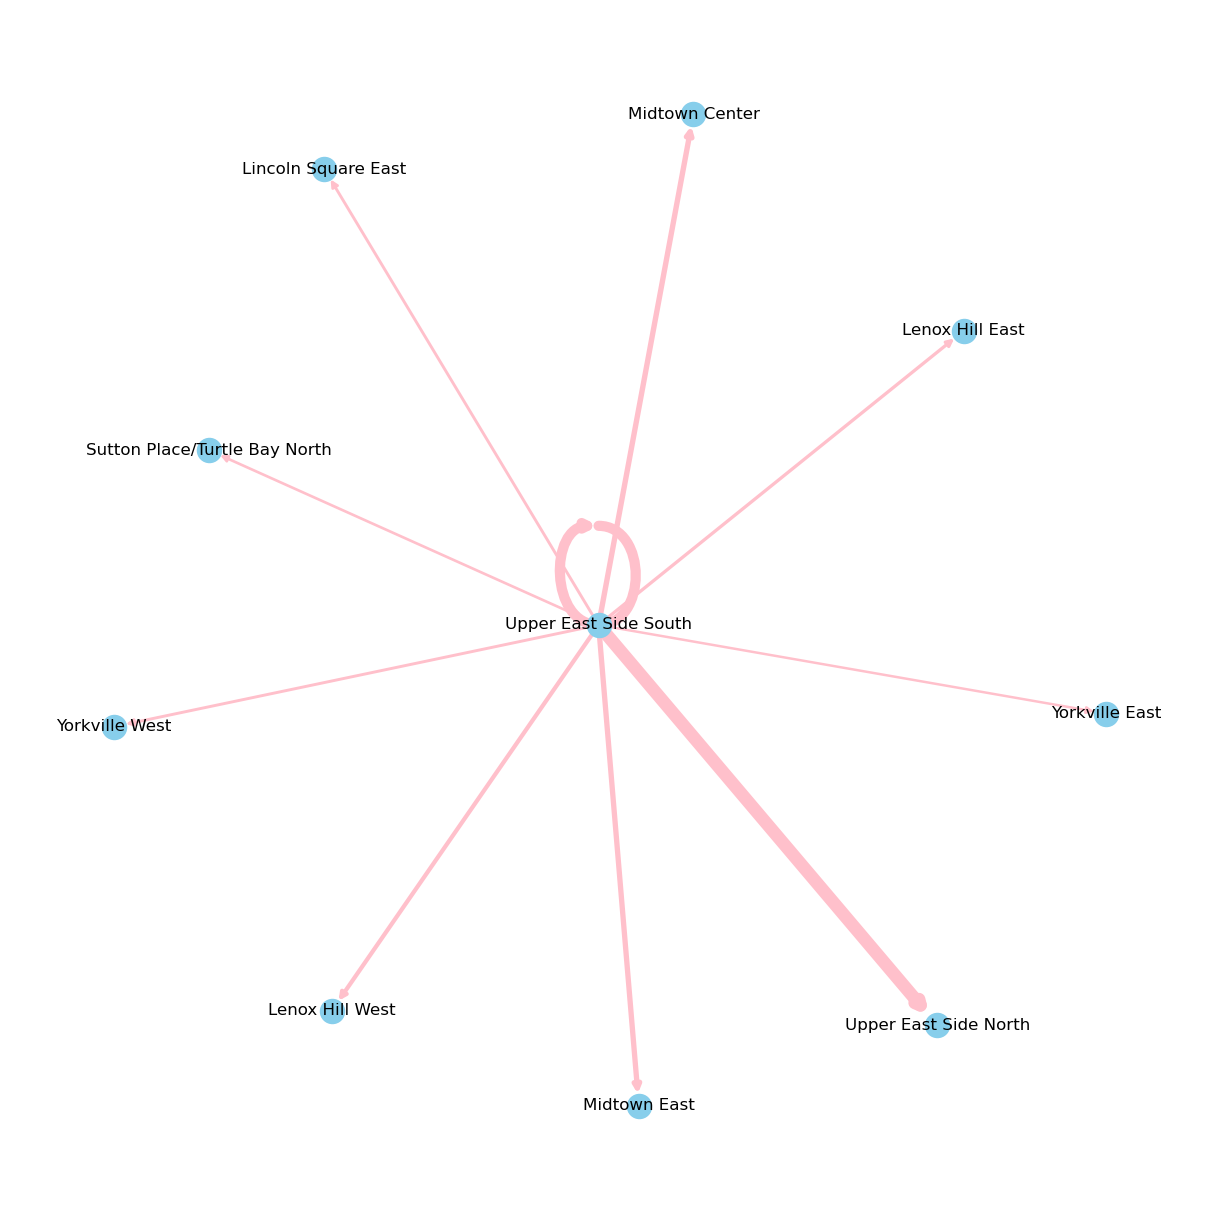

In [31]:
zone1 = graph.edges.groupBy("src","dst").count().orderBy("count", ascending=False).filter("src='Upper East Side South'"or "src='Upper East Side North'" or "src='Midtown Center'" or "src='Midtown East'" )
plotGraph(zone1.toPandas()[:10])

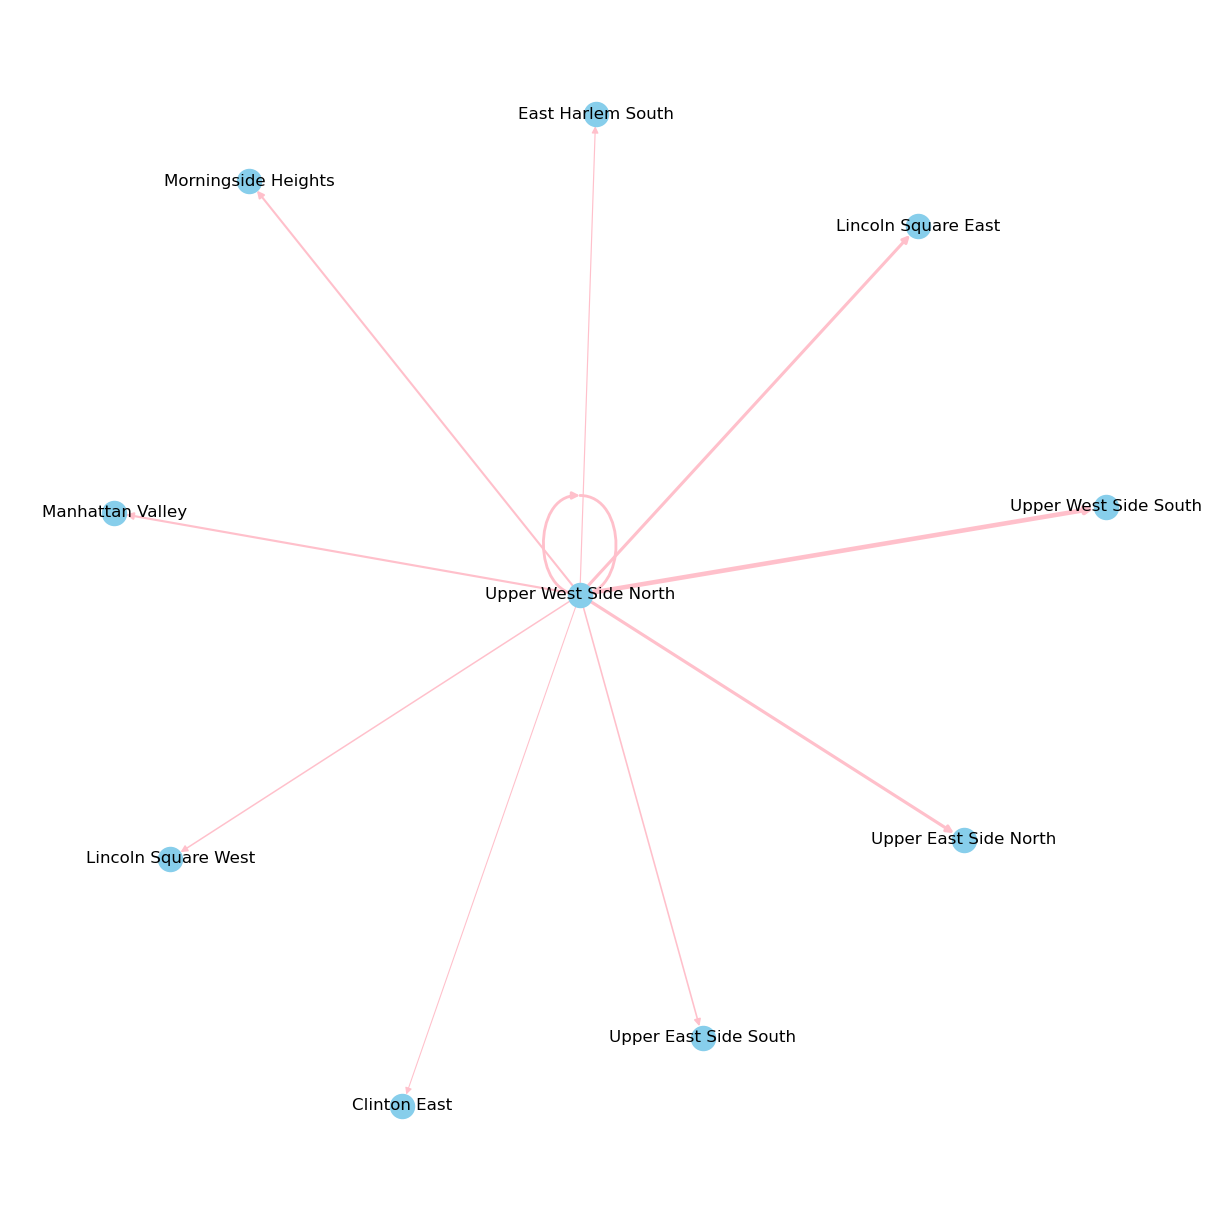

In [32]:
zone2 = graph.edges.groupBy("src","dst").count().orderBy("count", ascending=False).filter("src='Upper West Side North'" or "src='Upper West Side South'" or "src='Sowincoln Square East'")
plotGraph(zone2.toPandas()[:10])

In [33]:
page_rank_df = graph.pageRank(resetProbability=0.15, tol=0.01).vertices.orderBy('pagerank',ascending=False)


23/05/17 19:45:53 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [34]:
page_rank_df.select('id','pagerank').show(10)


+--------------------+------------------+
|                  id|          pagerank|
+--------------------+------------------+
|Upper East Side N...| 6.507835459528626|
|Upper East Side S...| 5.849757072114181|
|      Midtown Center| 5.470686477772386|
|         Murray Hill|  4.96166923465463|
|        Midtown East| 4.176515076835795|
|        Clinton East| 4.131982098764834|
| Lincoln Square East| 4.108839655432491|
|     Lenox Hill West|  4.09095442392657|
|Upper West Side S...| 4.054173510431857|
|Upper West Side N...|3.9177308580960566|
+--------------------+------------------+
only showing top 10 rows



In [35]:
page_rank_df=page_rank_df.toPandas()


NameError: name 'PR' is not defined

In [36]:
joined_PR = pd.merge(page_rank_df, gdf, left_on="id", right_on="zone", how="inner")

Text(0.5, 1.0, 'Polygon Plot with Pagerank')

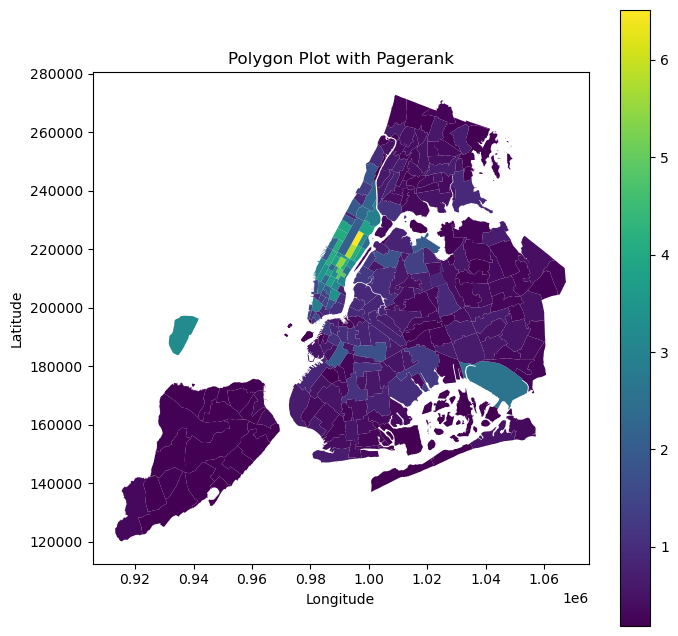

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
joined_PR = gpd.GeoDataFrame(joined_PR, geometry='geometry')
joined_PR.plot(ax=ax, column='pagerank', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Polygon Plot with Pagerank')

Text(0.5, 1.0, 'Speed (mile/min)')

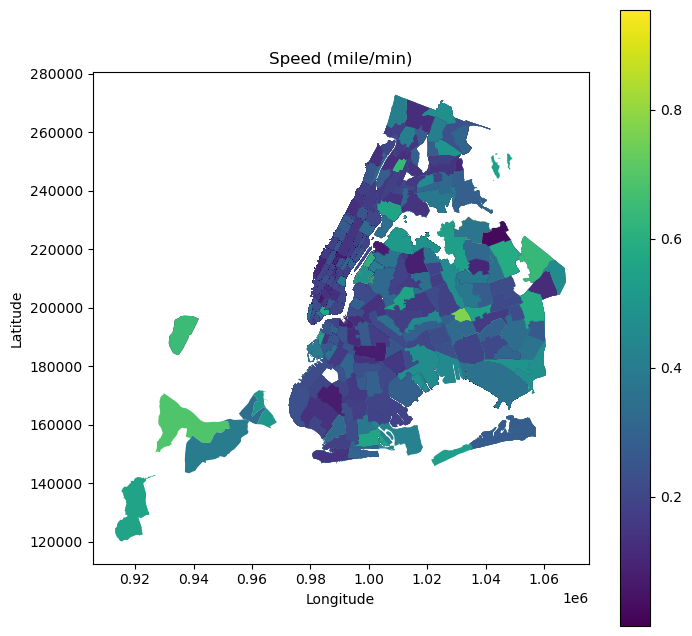

In [40]:
df_traffic=union_df.toPandas()
df_traffic = pd.merge(df_traffic, gdf, left_on="PULocationID", right_on="LocationID", how="inner")

df_traffic=df_traffic[df_traffic['Speed'] < 1]
df_traffic=df_traffic[df_traffic['Speed'] > 0]
fig, ax = plt.subplots(figsize=(8, 8))
df_traffic = gpd.GeoDataFrame(df_traffic, geometry='geometry')
df_traffic.plot(ax=ax, column='Speed', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Speed (mile/min)')



In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
joined_PR = gpd.GeoDataFrame(joined_PR, geometry='geometry')
joined_PR.plot(ax=ax, column='borough', legend=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Polygon Plot with Pagerank')

In [ ]:
# from pyspark.context import SparkContext
# from pyspark.sql import SparkSession
# from graphframes import *

# import pyspark.sql.functions as F 
# from pyspark.sql.functions import udf, explode, col,lit, split, regexp_replace, regexp_extract
# from pyspark.sql.types import StringType, ArrayType

# import networkx as nx
# import matplotlib.pyplot as plt
# from tqdm import tqdm

In [ ]:
# def plotGraph(pdf):
#     G = nx.from_pandas_edgelist(pdf[:50], "src", "dst", edge_attr=True, create_using=nx.MultiDiGraph())
#     counts = [i['count'] / 100 for i in dict(G.edges).values()]

#     plt.figure(figsize=(10, 10))
#     pos = nx.spring_layout(G)
#     edge_colors = range(len(G.edges()))  # Example: Assigning a range of colors to edges

#     nx.draw(
#         G,
#         with_labels=True,
#         node_color='skyblue',
#         width=counts,
#         edge_cmap=plt.cm.Blues,
#         edge_color='red',
#         font_size=9,
#         #edge_colors = (0.24, 0.24, 0.0), # Set the edge color
#         pos=pos
#     )
#     plt.show()

In [ ]:
# # create a directed-graph from a dataframe
# def plotGraph(pdf):
#     G=nx.from_pandas_edgelist(pdf[:50], "src", "dst", 
#                               edge_attr=True, create_using=nx.MultiDiGraph())
#     counts = [i['count']/100 for i in dict(G.edges).values()]

#     plt.figure(figsize=(8,8))
#     pos = nx.spring_layout(G)
#     nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
#     plt.show()

In [ ]:
# # top 10 most frequent taxi routes in NYC
# plt.figure(figsize=(10, 6))
# plotGraph(RouteCount.toPandas()[:10])

#### Clustering

In [45]:
from pyspark.sql.functions import col

# Create a GraphFrame object with the graph data
vertices_df = graph.vertices

# Create a dataframe with the inDegree, outDegree of each vertex
in_degrees_df = indegree.withColumnRenamed("id", "inDegreeId").withColumnRenamed("inDegree", "inDegreeVal")
out_degrees_df = outdegree.withColumnRenamed("id", "outDegreeId").withColumnRenamed("outDegree", "outDegreeVal")

# Join the dataframes to create a new dataframe with the inDegree, outDegree, and pageRank of each vertex
vertex_props_df = vertices_df \
    .join(in_degrees_df, vertices_df.id == in_degrees_df.inDegreeId, "left_outer") \
    .join(out_degrees_df, vertices_df.id == out_degrees_df.outDegreeId, "left_outer") \
    .join(page_rank_df, vertices_df.id == page_rank_df.id, "left_outer") \
    .select(vertices_df.id, col("inDegreeVal"), col("outDegreeVal"), col("pagerank"))

Py4JJavaError: An error occurred while calling o349.equalTo.
: java.lang.RuntimeException: Unsupported literal type class java.util.HashMap {0=Upper East Side North, 1=Upper East Side South, 2=Midtown Center, 3=Murray Hill, 4=Midtown East, 5=Clinton East, 6=Lincoln Square East, 7=Lenox Hill West, 8=Upper West Side South, 9=Upper West Side North, 10=East Harlem South, 11=Times Sq/Theatre District, 12=Penn Station/Madison Sq West, 13=Lenox Hill East, 14=Union Sq, 15=East Chelsea, 16=East Village, 17=Yorkville West, 18=Sutton Place/Turtle Bay North, 19=Midtown South, 20=Midtown North, 21=Newark Airport, 22=Gramercy, 23=Kips Bay, 24=West Chelsea/Hudson Yards, 25=TriBeCa/Civic Center, 26=East Harlem North, 27=JFK Airport, 28=UN/Turtle Bay South, 29=West Village, 30=Yorkville East, 31=Flatiron, 32=Lincoln Square West, 33=Garment District, 34=Central Harlem, 35=Central Harlem North, 36=Greenwich Village North, 37=Central Park, 38=Park Slope, 39=LaGuardia Airport, 40=Manhattan Valley, 41=Morningside Heights, 42=Clinton West, 43=Washington Heights South, 44=Astoria, 45=Lower East Side, 46=Crown Heights North, 47=Financial District North, 48=Meatpacking/West Village West, 49=Battery Park City, 50=Little Italy/NoLiTa, 51=Greenwich Village South, 52=Jackson Heights, 53=SoHo, 54=Hamilton Heights, 55=East New York, 56=Brooklyn Heights, 57=Queensbridge/Ravenswood, 58=Long Island City/Hunters Point, 59=Mott Haven/Port Morris, 60=Boerum Hill, 61=Prospect-Lefferts Gardens, 62=Flatbush/Ditmas Park, 63=World Trade Center, 64=Two Bridges/Seward Park, 65=Financial District South, 66=Clinton Hill, 67=Alphabet City, 68=Canarsie, 69=Fort Greene, 70=Sunnyside, 71=Washington Heights North, 72=Hudson Sq, 73=Chinatown, 74=Williamsburg (North Side), 75=Williamsburg (South Side), 76=Forest Hills, 77=Greenpoint, 78=Schuylerville/Edgewater Park, 79=Manhattanville, 80=Downtown Brooklyn/MetroTech, 81=Corona, 82=Corona, 83=Sunset Park West, 84=East Williamsburg, 85=Bloomingdale, 86=Stuyvesant Heights, 87=Bushwick South, 88=Bedford, 89=Steinway, 90=East Concourse/Concourse Village, 91=Flatlands, 92=Stuy Town/Peter Cooper Village, 93=Old Astoria, 94=Elmhurst, 95=East Elmhurst, 96=Coney Island, 97=Richmond Hill, 98=Co-Op City, 99=Seaport, 100=Bushwick North, 101=Jamaica, 102=Mount Hope, 103=Bay Terrace/Fort Totten, 104=Van Nest/Morris Park, 105=Spuyten Duyvil/Kingsbridge, 106=Bay Ridge, 107=Ridgewood, 108=South Ozone Park, 109=DUMBO/Vinegar Hill, 110=Ozone Park, 111=Bath Beach, 112=Carroll Gardens, 113=West Concourse, 114=Ocean Hill, 115=University Heights/Morris Heights, 116=East New York/Pennsylvania Avenue, 117=Flushing, 118=Highbridge, 119=Woodside, 120=Long Island City/Queens Plaza, 121=Baisley Park, 122=Saint Michaels Cemetery/Woodside, 123=East Flatbush/Farragut, 124=Prospect Heights, 125=Williamsbridge/Olinville, 126=Crown Heights South, 127=Homecrest, 128=Briarwood/Jamaica Hills, 129=Parkchester, 130=Borough Park, 131=Red Hook, 132=Brownsville, 133=Saint Albans, 134=Soundview/Castle Hill, 135=East Flatbush/Remsen Village, 136=Hammels/Arverne, 137=Pelham Bay, 138=Bronx Park, 139=Erasmus, 140=Inwood, 141=Sunset Park East, 142=South Jamaica, 143=Van Cortlandt Village, 144=Gowanus, 145=Queens Village, 146=East Tremont, 147=Pelham Parkway, 148=Bedford Park, 149=Flushing Meadows-Corona Park, 150=Midwood, 151=Norwood, 152=Elmhurst/Maspeth, 153=Douglaston, 154=Melrose South, 155=Kew Gardens, 156=Brighton Beach, 157=Maspeth, 158=South Williamsburg, 159=Bensonhurst West, 160=Gravesend, 161=Morrisania/Melrose, 162=Madison, 163=Hillcrest/Pomonok, 164=Cobble Hill, 165=North Corona, 166=Auburndale, 167=Starrett City, 168=Kensington, 169=West Farms/Bronx River, 170=Kingsbridge Heights, 171=Glendale, 172=Manhattan Beach, 173=Westchester Village/Unionport, 174=Allerton/Pelham Gardens, 175=Marine Park/Mill Basin, 176=Bronxdale, 177=Laurelton, 178=Belmont, 179=Fresh Meadows, 180=Stapleton, 181=Claremont/Bathgate, 182=Hunts Point, 183=Randalls Island, 184=Dyker Heights, 185=Soundview/Bruckner, 186=Roosevelt Island, 187=Rego Park, 188=Far Rockaway, 189=Springfield Gardens North, 190=Charleston/Tottenville, 191=Windsor Terrace, 192=Springfield Gardens South, 193=Sheepshead Bay, 194=Kew Gardens Hills, 195=Cypress Hills, 196=Middle Village, 197=Glen Oaks, 198=Cambria Heights, 199=Longwood, 200=Murray Hill-Queens, 201=Oakland Gardens, 202=Bensonhurst East, 203=Fordham South, 204=Rosedale, 205=Battery Park, 206=Howard Beach, 207=Jamaica Estates, 208=Bayside, 209=Prospect Park, 210=Woodhaven, 211=Ocean Parkway South, 212=Brooklyn Navy Yard, 213=Inwood Hill Park, 214=Whitestone, 215=Woodlawn/Wakefield, 216=Queensboro Hill, 217=Crotona Park East, 218=Riverdale/North Riverdale/Fieldston, 219=Columbia Street, 220=Hollis, 221=College Point, 222=Eastchester, 223=Arden Heights, 224=Bellerose, 225=Willets Point, 226=City Island, 227=Marble Hill, 228=Bloomfield/Emerson Hill, 229=West Brighton, 230=Mariners Harbor, 231=Heartland Village/Todt Hill, 232=East Flushing, 233=Van Cortlandt Park, 234=Rockaway Park, 235=Breezy Point/Fort Tilden/Riis Beach, 236=Highbridge Park, 237=Pelham Bay Park, 238=Astoria Park, 239=South Beach/Dongan Hills, 240=Arrochar/Fort Wadsworth, 241=Grymes Hill/Clifton, 242=Green-Wood Cemetery, 243=Oakwood, 244=Country Club, 245=Saint George/New Brighton, 246=Westerleigh, 247=New Dorp/Midland Beach, 248=Forest Park/Highland Park, 249=Broad Channel, 250=Freshkills Park, 251=Great Kills, 252=Governor's Island/Ellis Island/Liberty Island, 253=Governor's Island/Ellis Island/Liberty Island, 254=Governor's Island/Ellis Island/Liberty Island, 255=Jamaica Bay, 256=Rikers Island, 257=Rossville/Woodrow, 258=Eltingville/Annadale/Prince's Bay, 259=Great Kills Park, 260=Port Richmond, 261=Marine Park/Floyd Bennett Field, 262=Crotona Park}
	at org.apache.spark.sql.catalyst.expressions.Literal$.apply(literals.scala:90)
	at org.apache.spark.sql.catalyst.expressions.Literal$.$anonfun$create$2(literals.scala:152)
	at scala.util.Failure.getOrElse(Try.scala:222)
	at org.apache.spark.sql.catalyst.expressions.Literal$.create(literals.scala:152)
	at org.apache.spark.sql.functions$.typedLit(functions.scala:131)
	at org.apache.spark.sql.functions$.lit(functions.scala:114)
	at org.apache.spark.sql.Column.$eq$eq$eq(Column.scala:278)
	at org.apache.spark.sql.Column.equalTo(Column.scala:301)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:750)


In [ ]:
vertex_props_df = vertex_props_df.fillna(0)

In [ ]:
# Cluster the vertices based on the inDegree, outDegree, and pagerank using KMeans
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import VectorAssembler

# Assemble the features into a vector
assembler = VectorAssembler(inputCols=["inDegreeVal", "outDegreeVal","pagerank"], outputCol="features")
data = assembler.transform(vertex_props_df).select("id", "features")

In [ ]:
#Create and fit the Bisecting K-means model:
num_clusters = 3  # Set the desired number of clusters
bisecting_kmeans = BisectingKMeans(k=num_clusters, seed=42)
model = bisecting_kmeans.fit(data)

In [ ]:
# Obtain the cluster assignments for each vertex
predictions = model.transform(data)

In [ ]:
# Evaluate the clustering
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette score:", silhouette)

In [ ]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pdf = predictions.select("id", "prediction").toPandas()

# Merge the Pandas DataFrame with the vertex properties DataFrame
merged_df = pd.merge(vertex_props_df.toPandas(), pdf, on="id")

# Scatter plot the clusters
plt.scatter(merged_df["inDegreeVal"], merged_df["outDegreeVal"], c=merged_df["prediction"], s=merged_df["pagerank"] * 50)
plt.xlabel("inDegree")
plt.ylabel("outDegree")
plt.show()